# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.set_option('display.float_format', '{:,.2f}'.format)
data = pd.read_csv('/datasets/autos.csv')
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [3]:
data.shape

(354369, 16)

In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,"354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00"
mean,"4,416.66","2,004.23",110.09,"128,211.17",5.71,0.00,"50,508.69"
std,"4,514.16",90.23,189.85,"37,905.34",3.73,0.00,"25,783.10"
min,0.00,"1,000.00",0.00,"5,000.00",0.00,0.00,"1,067.00"
25%,"1,050.00","1,999.00",69.00,"125,000.00",3.00,0.00,"30,165.00"
50%,"2,700.00","2,003.00",105.00,"150,000.00",6.00,0.00,"49,413.00"
75%,"6,400.00","2,008.00",143.00,"150,000.00",9.00,0.00,"71,083.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00",12.00,0.00,"99,998.00"


In [5]:
data.duplicated().sum()

4

In [6]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

In [7]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

<div class="alert alert-info"> <b>Комментарий студента:</b> 

Удалим ненужные признаки 'DateCrawled', 'NumberOfPictures', 'DateCreated', 'LastSeen', 'RegistrationMonth'.
    
Удалили 4 дубликата.
    
Есть пропуски в 5 столбцах:
    
- 'NotRepaired' значение да/нет заменим на 1 и 0, предположим что пропуски это небитые заменим на 0.
    
- 'VehicleType', 'Gearbox', 'FuelType' заменим на более частые значения.

- 'Model' пропуски заменим на unknow. 
    
</div>

<div class="alert alert-info"> <b>Комментарий студента V2:</b> 

Так как задача стоит быстрый поиск авто по ТТХ, то признаки не связанные с авто будут влиять на скорость поиска и точность результата.    
    
Признаки: 'DateCrawled', 'DateCreated', 'LastSeen' - эти признаки относятся к самому обьявлению.
    
Признак 'NumberOfPictures' - кроме одной строки все остальные значения нулевые.    
    
Признак 'RegistrationMonth' - месяц регистрации не нужен для подбора авто.
    
</div>

In [4]:
# Удалим столбци
data = data.drop(labels=['DateCrawled', 'NumberOfPictures', 'DateCreated', 'LastSeen', 'RegistrationMonth'], axis=1)

In [5]:
# заменим да/нет в 'NotRepaired', обработаем пропуски
data['NotRepaired'] = data['NotRepaired'].map({'yes': 1, 'no': 0})
data['NotRepaired'] = data['NotRepaired'].fillna('0').astype('int')
data.head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,0,70435
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,1,66954
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0,91074
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0,60437
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,1,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,0,67112
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,0,19348
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,0,94505
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,0,27472


In [6]:
# заменим пропуски в 'VehicleType', 'Gearbox', 'FuelType', 'Model'
data['Model'] = data['Model'].fillna('unknow')
#data['VehicleType'] = data.groupby(['Brand', 'Model'])['VehicleType'].transform(
#    lambda x: x.fillna(value=(x.mode()[0] if not x.mode().empty else "Empty")))
#data['Gearbox'] = data.groupby(['Brand', 'Model'])['Gearbox'].transform(
#    lambda x: x.fillna(value=(x.mode()[0] if not x.mode().empty else "Empty")))
#data['FuelType'] = data.groupby(['Brand', 'Model'])['FuelType'].transform(
#    lambda x: x.fillna(value=(x.mode()[0] if not x.mode().empty else "Empty")))
#data.head(10)

columns = ['VehicleType', 'Gearbox', 'FuelType']

for column in columns:
    data[column] = data.groupby(['Brand', 'Model'])[column].transform(
    lambda x: x.fillna(value=(x.mode()[0] if not x.mode().empty else "Empty")))
    
data.head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,0,70435
1,18300,coupe,2011,manual,190,unknow,125000,gasoline,audi,1,66954
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0,91074
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0,60437
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,1,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,0,67112
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,0,19348
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,0,94505
9,999,small,1998,manual,101,golf,150000,petrol,volkswagen,0,27472


In [11]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
PostalCode          0
dtype: int64

In [12]:
data.shape

(354365, 11)

In [13]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,NotRepaired,PostalCode
count,"354,365.00","354,365.00","354,365.00","354,365.00","354,365.00","354,365.00"
mean,"4,416.68","2,004.23",110.09,"128,211.36",0.10,"50,508.50"
std,"4,514.18",90.23,189.85,"37,905.08",0.30,"25,783.10"
min,0.00,"1,000.00",0.00,"5,000.00",0.00,"1,067.00"
25%,"1,050.00","1,999.00",69.00,"125,000.00",0.00,"30,165.00"
50%,"2,700.00","2,003.00",105.00,"150,000.00",0.00,"49,413.00"
75%,"6,400.00","2,008.00",143.00,"150,000.00",0.00,"71,083.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00",1.00,"99,998.00"


In [14]:
def boxplot(data, column, title, figsize=(15,3), color='blue', xlabel='', xlim=None):
        plt.figure(figsize=figsize)

        ax = sns.boxplot(x=data[column], color=color)

        if (xlim != None):
            plt.xlim(xlim)

        ax.set(xlabel=xlabel, title=title)

In [15]:
def histogram(data, column, title, figsize=(14,5), color='blue', xlabel='', ylabel='', kde=False,
              bins=None, xticks=0, xlim=None, ylim=None):
        plt.figure(figsize=figsize)

        ax = sns.distplot(data[column], color=color, kde=kde, bins=bins)

        if (xlim != None):
            plt.xlim(xlim)
        if (ylim != None):
            plt.ylim(ylim)

        ax.set(xlabel=xlabel, ylabel=ylabel, title=title)

        if xticks != 0:
            ax.set(xticks=xticks)

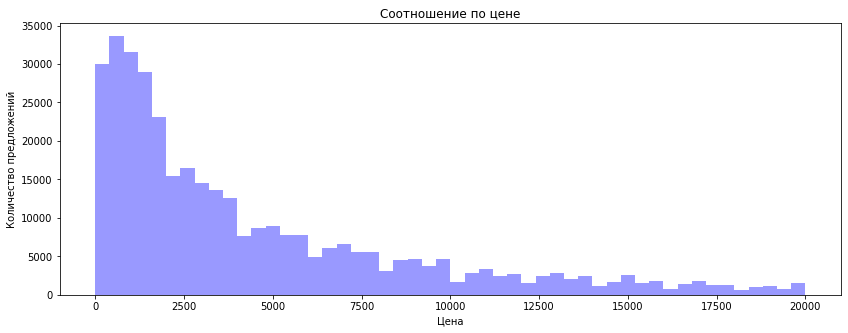

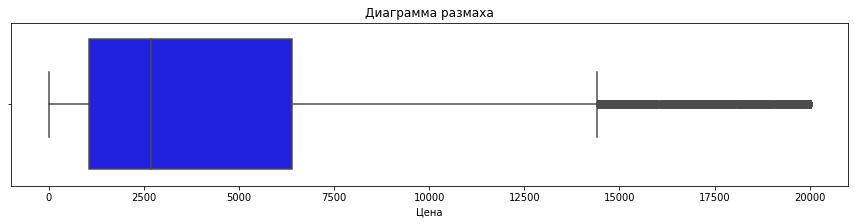

In [16]:
histogram(data, 'Price', 'Соотношение по цене', 
                      xlabel='Цена', ylabel='Количество предложений')
boxplot(data, 'Price', 'Диаграмма размаха', 
                    xlabel='Цена')

In [17]:
# Проверим количество 0 значений
data.query('Price ==0').shape[0]

10772

Вывод: Почти 11 т. записей с 0 ценной, цена авто не должна быть 0, удалим. 

In [7]:
data_upd = data.query('Price != 0')

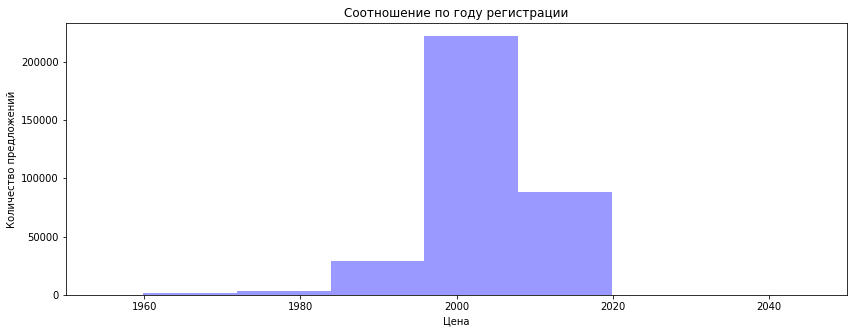

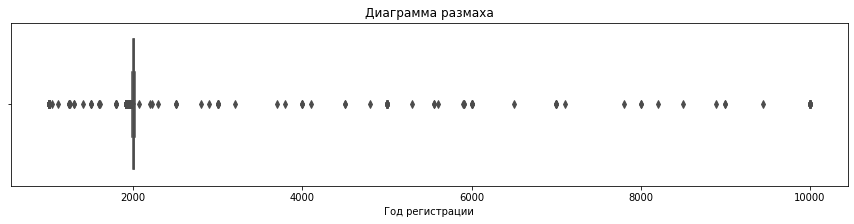

In [19]:
histogram(data_upd, 'RegistrationYear', 'Соотношение по году регистрации', 
                      xlabel='Цена', ylabel='Количество предложений', xlim=(1950, 2050), bins=750)
boxplot(data_upd, 'RegistrationYear', 'Диаграмма размаха', 
                    xlabel='Год регистрации')

In [20]:
data_upd.query('RegistrationYear > 2020').shape[0]

86

Вывод: Выбросов после 2020 г., удалим их.

In [8]:
data_upd = data_upd.query('RegistrationYear < 2020')

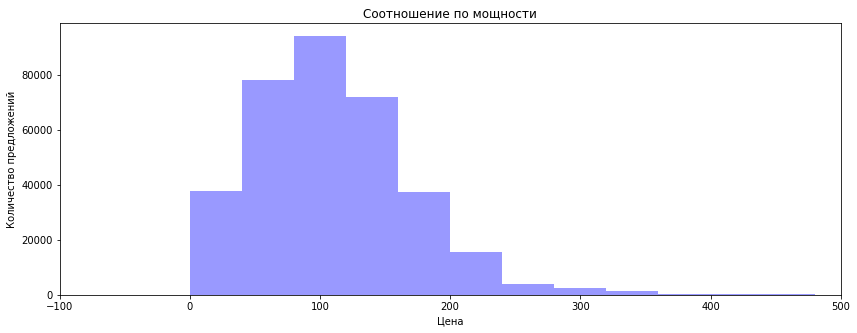

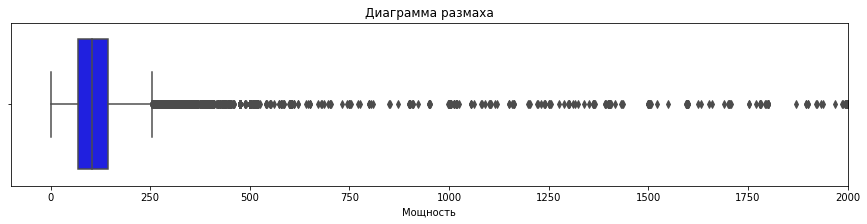

In [22]:
histogram(data_upd, 'Power', 'Соотношение по мощности', 
                      xlabel='Цена', ylabel='Количество предложений', xlim=(-100,500), bins=500)
boxplot(data_upd, 'Power', 'Диаграмма размаха', 
                    xlabel='Мощность', xlim=(-100, 2000))

In [23]:
print(data_upd.query('0 <= Power < 30').shape[0])
print(data_upd.query('Power > 1000').shape[0])

37155
284


Вывод: Есть 284 значения больше 1000 л.с. и ~ 37 т. значение от 0 до 30 л.с., то что больше 1000 лс удалим, остальное будем анализировать.

In [9]:
data_upd = data_upd.query('Power < 1000')

Вывод: заменим значения ниже 30 лс на nan, затем как делали выше заменим на среднее.

In [10]:
data_upd.loc[(data_upd['Power'] <= 20), 'Power'] = 0
data_upd['Power'].replace(0, np.nan, inplace=True)
median = data_upd.groupby(['Brand', 'Model', 'FuelType', 'Gearbox', 'RegistrationYear', 
                           'VehicleType'])['Power'].transform('median')
data_upd['Power'] = data_upd.groupby(['Brand', 'Model'])['Power'].transform(
    lambda x: x.fillna(value=(x.mode()[0] if not x.mode().empty else median)))

In [26]:
data_upd.describe()

,Price,RegistrationYear,Power,Kilometer,NotRepaired,PostalCode
count,"343,216.00","343,216.00","343,215.00","343,216.00","343,216.00","343,216.00"
mean,"4,556.59","2,003.07",118.66,"128,371.23",0.10,"50,689.79"
std,"4,515.62",12.62,53.89,"37,469.16",0.30,"25,744.96"
min,1.00,"1,000.00",21.00,"5,000.00",0.00,"1,067.00"
25%,"1,200.00","1,999.00",75.00,"125,000.00",0.00,"30,449.00"
50%,"2,890.00","2,003.00",109.00,"150,000.00",0.00,"49,525.00"
75%,"6,500.00","2,008.00",145.00,"150,000.00",0.00,"71,229.00"
max,"20,000.00","2,019.00",999.00,"150,000.00",1.00,"99,998.00"


In [27]:
data_upd.dropna(inplace=True)

<AxesSubplot:>

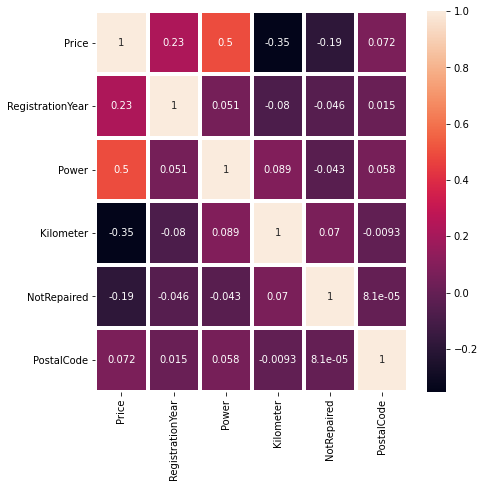

In [28]:
plt.rcParams['figure.figsize'] = (7.0, 7.0)
sns.heatmap(data_upd.corr(), annot=True, linewidths=3, linecolor='white')

<div class="alert alert-info"> <b>Комментарий студента:</b> 

Из 16 признаков в датасет осталось 11, что должно повысить скорость поиска подходящей модели авто. 

Пропусков нет, дубликатов нет. 
    
</div>

<div class="alert alert-info"> <b>Комментарий студента V2:</b> 

Допустил ошибку не проверив на выбросы и аномалии.
    
- Удалил аномалии в столбце 'Price', 'RegistrationYear', 'Power'. 
    
- Диаграмма ХитМап показывает слабую корреляцию не больше 0,5 по отношению к цене.
    
- Так же поменял тип данных. 
    
</div>

In [11]:
# Преобразуем категориальные признаки
ord_df = data_upd.copy()

In [12]:
columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
encoder = OrdinalEncoder()
encoder.fit(ord_df[columns])
ord_df[columns] = encoder.transform(ord_df[columns])
ord_df.head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode
0,480,4.00,1993,1.00,75.00,116.00,150000,6.00,38.00,0.00,70435
1,18300,2.00,2011,1.00,190.00,228.00,125000,2.00,1.00,1.00,66954
2,9800,6.00,2004,0.00,163.00,117.00,125000,2.00,14.00,0.00,90480
3,1500,5.00,2001,1.00,75.00,116.00,150000,6.00,38.00,0.00,91074
4,3600,5.00,2008,1.00,69.00,101.00,90000,2.00,31.00,0.00,60437
5,650,4.00,1995,1.00,102.00,11.00,150000,6.00,2.00,1.00,33775
6,2200,1.00,2004,1.00,109.00,8.00,150000,6.00,25.00,0.00,67112
8,14500,0.00,2014,1.00,125.00,60.00,30000,6.00,10.00,0.00,94505
9,999,5.00,1998,1.00,101.00,116.00,150000,6.00,38.00,0.00,27472
10,2000,4.00,2004,1.00,105.00,10.00,150000,6.00,19.00,0.00,96224


In [31]:
# Выделим признаки для обучения модели
features = ord_df.drop('Price', axis=1)
target = ord_df.Price

print(features.shape)
print(target.shape)

(343215, 10)
(343215,)


In [32]:
# разабьем данные на обучающий+проверочный и тестовый набор
X_trainval, X_test, y_trainval, y_test = train_test_split(features, target, random_state=0)

# разабьем данные обучающий+проверочный на  обучающий и проверочный набор
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)

print(f'Размер обучающего набора: {X_train.shape}, размер проверочного набора: {X_valid.shape}, размер тестового набора: {X_test.shape}')

Размер обучающего набора: (193058, 10), размер проверочного набора: (64353, 10), размер тестового набора: (85804, 10)


In [33]:
# предварительная обработка числовых признаков с помощью масштабирования
numeric = ['RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(X_trainval[numeric])

X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

## Обучение моделей

### модель LightGBM

In [34]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [35]:
params = {'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': {'rmse'},
          'num_leaves': 31,
          'learning_rate': 0.5,
          'verbose': 0,
          'max_depth':5,
          'min_data_in_leaf':100
}

In [36]:
%%time
model = lgb.train(params, lgb_train, num_boost_round=25, valid_sets=lgb_valid, early_stopping_rounds=5)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's rmse: 3125.18
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 2576.41
[3]	valid_0's rmse: 2345.45
[4]	valid_0's rmse: 2235.96
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 2159.99
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 2118.49
[Li

In [37]:
%%time
prediction = model.predict(X_valid, num_iteration=model.best_iteration)
print('RMSE:', mean_squared_error(y_valid, prediction, squared=False))

RMSE: 1895.3927468488607
CPU times: user 127 ms, sys: 3.43 ms, total: 130 ms
Wall time: 100 ms


In [38]:
%%time
prediction = model.predict(X_test, num_iteration=model.best_iteration)
print('RMSE:', mean_squared_error(y_test, prediction, squared=False))

RMSE: 1874.4319242789659
CPU times: user 161 ms, sys: 0 ns, total: 161 ms
Wall time: 107 ms


In [39]:
params = {'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': {'rmse'},
          'num_leaves': 50,
          'learning_rate': 0.5,
          'verbose': 0,
          'max_depth':25,
          'min_data_in_leaf':100
}

In [40]:
%%time
model = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_valid, early_stopping_rounds=5)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's rmse: 3034.8
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 2459.78
[3]	valid_0's rmse: 2218.39
[4]	valid_0's rmse: 2108.28
[5]	valid_0's rmse: 2032.48
[6]	valid_0's rmse: 1984.19
[7]	valid_0's rmse: 1955.26
[8]	valid_0's rmse: 1943.04
[9]	valid_0's rmse: 1924.73
[10]	valid_0's rmse: 1909.01
[11]	valid_0's rmse: 1899.25
[12]	valid_0's rmse: 1893.34
[13]	valid_0's rmse: 1884.06
[14]	valid_0's rmse: 1876.27
[15]	valid_0's rmse: 1865.49
[16]	valid_0's rmse: 1858.

In [41]:
%%time
prediction = model.predict(X_valid, num_iteration=model.best_iteration)
print('RMSE:', mean_squared_error(y_valid, prediction, squared=False))

RMSE: 1744.9538716913787
CPU times: user 446 ms, sys: 0 ns, total: 446 ms
Wall time: 493 ms


In [42]:
%%time
prediction = model.predict(X_test, num_iteration=model.best_iteration)
print('RMSE:', mean_squared_error(y_test, prediction, squared=False))

RMSE: 1731.566782979307
CPU times: user 588 ms, sys: 1.35 ms, total: 590 ms
Wall time: 594 ms


<div class="alert alert-info"> <b>Комментарий студента:</b> 

Меняя количество листьев 'num_leaves', глубину дерева 'max_depth' и количество циклов бустинга 'num_boost_round' мы улучшаем точность обучения RMSE, но увеличевается время обучения и предсказания. 
    
</div>

### модель CatBoost

In [43]:
from catboost import CatBoostRegressor

In [44]:
params = {'iterations':25, 
          'eval_metric':'RMSE', 
          'verbose': 3,
          'random_seed': 42
         }

In [45]:
model = CatBoostRegressor(**params)

In [46]:
%%time
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

Learning rate set to 0.5
0:	learn: 3231.1766060	test: 3223.1166728	best: 3223.1166728 (0)	total: 84ms	remaining: 2.02s
3:	learn: 2307.7727820	test: 2325.3920831	best: 2325.3920831 (3)	total: 166ms	remaining: 872ms
6:	learn: 2139.4564300	test: 2160.9721104	best: 2160.9721104 (6)	total: 243ms	remaining: 624ms
9:	learn: 2046.3648678	test: 2071.2006040	best: 2071.2006040 (9)	total: 332ms	remaining: 498ms
12:	learn: 2004.0824231	test: 2032.7487361	best: 2032.7487361 (12)	total: 410ms	remaining: 378ms
15:	learn: 1970.3929924	test: 1999.3396361	best: 1999.3396361 (15)	total: 486ms	remaining: 273ms
18:	learn: 1955.5636448	test: 1984.8693969	best: 1984.8693969 (18)	total: 563ms	remaining: 178ms
21:	learn: 1936.8377830	test: 1968.3156249	best: 1968.3156249 (21)	total: 641ms	remaining: 87.5ms
24:	learn: 1912.5124737	test: 1946.4860221	best: 1946.4860221 (24)	total: 723ms	remaining: 0us

bestTest = 1946.486022
bestIteration = 24

CPU times: user 830 ms, sys: 16.5 ms, total: 846 ms
Wall time: 2.01 

In [47]:
%%time
prediction = model.predict(X_test)
print('RMSE:', mean_squared_error(y_test, prediction, squared=False))

RMSE: 1921.5872372776216
CPU times: user 13.6 ms, sys: 102 µs, total: 13.7 ms
Wall time: 11.5 ms


In [48]:
params = {'iterations':100, 
          'learning_rate': 0.5,
          'eval_metric':'RMSE', 
          'use_best_model': True,
          'verbose': 3,
          'random_seed': 42
         }

In [49]:
model = CatBoostRegressor(**params)

In [50]:
%%time
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

0:	learn: 3231.1766060	test: 3223.1166728	best: 3223.1166728 (0)	total: 33ms	remaining: 3.27s
3:	learn: 2307.7727820	test: 2325.3920831	best: 2325.3920831 (3)	total: 116ms	remaining: 2.79s
6:	learn: 2139.4564300	test: 2160.9721104	best: 2160.9721104 (6)	total: 194ms	remaining: 2.57s
9:	learn: 2046.3648678	test: 2071.2006040	best: 2071.2006040 (9)	total: 274ms	remaining: 2.46s
12:	learn: 2004.0824231	test: 2032.7487361	best: 2032.7487361 (12)	total: 356ms	remaining: 2.38s
15:	learn: 1970.3929924	test: 1999.3396361	best: 1999.3396361 (15)	total: 437ms	remaining: 2.29s
18:	learn: 1955.5636448	test: 1984.8693969	best: 1984.8693969 (18)	total: 513ms	remaining: 2.19s
21:	learn: 1936.8377830	test: 1968.3156249	best: 1968.3156249 (21)	total: 591ms	remaining: 2.1s
24:	learn: 1912.5124737	test: 1946.4860221	best: 1946.4860221 (24)	total: 672ms	remaining: 2.02s
27:	learn: 1900.0649366	test: 1935.1949567	best: 1935.1949567 (27)	total: 751ms	remaining: 1.93s
30:	learn: 1887.1867865	test: 1921.02954

In [51]:
%%time
prediction = model.predict(X_test)
print('RMSE:', mean_squared_error(y_test, prediction, squared=False))

RMSE: 1784.165052373117
CPU times: user 18.9 ms, sys: 134 µs, total: 19 ms
Wall time: 17.1 ms


<div class="alert alert-info"> <b>Комментарий студента:</b> 

Меняя количество интераций 'iterations', время обучения 'learning_rate', мы улучшаем точность обучения RMSE, но увеличевается время обучения и предсказания. 
    
</div>

### модель DecisionTreeRegressor

In [52]:
from sklearn.tree import DecisionTreeRegressor

In [1]:
# Функция обучения

def fit(features, target, n= 20, nu= 0.1, verbose = 10):
    features = features.copy()
    target = target.copy()
    model = []
    features['y_pred'] = target.mean()
    features['residual'] = 0
    for i in range(n):
        features['residual'] = target - features['y_pred']
        tree = DecisionTreeRegressor(max_depth=5)
        tree.fit(features.drop(['residual','y_pred'],axis=1), features['residual'])
        features['y_pred'] += nu * tree.predict(features.drop(['residual','y_pred'],axis=1))
        model.append(tree)
        if i % verbose == 0:
            print(f'{i} RMSE:', mean_squared_error(target, features['y_pred'], squared=False))
    print(f'{n} RMSE:', mean_squared_error(target, features['y_pred'], squared=False))
    return model

In [54]:
%%time
model = fit(X_train, y_train)

0 RMSE: 4210.0713707704945
10 RMSE: 2616.1784766780434
20 RMSE: 2218.642223394075
CPU times: user 6.19 s, sys: 6.68 ms, total: 6.2 s
Wall time: 6.2 s


In [55]:
# Функция предсказания

def pred(features, target, model, nu = 0.1):
    features = features.copy()
    target = target.copy()
    features['y_pred'] = target.mean()
    features['residual'] = 0
    for tree in model:
        features['y_pred'] += nu * tree.predict(features.drop(['residual','y_pred'],axis=1))
        print(f'RMSE:', mean_squared_error(target, features['y_pred'], squared=False))

In [56]:
%%time 
pred(X_test, y_test, model)

RMSE: 4204.910535757241
RMSE: 3932.4704474794803
RMSE: 3696.819706497792
RMSE: 3487.611096696436
RMSE: 3307.274929985838
RMSE: 3151.2751403560774
RMSE: 3008.1229979298164
RMSE: 2882.9768964473033
RMSE: 2779.314215472375
RMSE: 2685.6074038737884
RMSE: 2605.1250473250434
RMSE: 2536.5822187240465
RMSE: 2478.6100095787588
RMSE: 2424.0930378645135
RMSE: 2375.800277065186
RMSE: 2335.502398770958
RMSE: 2299.0164044618855
RMSE: 2266.1772708179737
RMSE: 2237.4919869044866
RMSE: 2213.5715926517287
CPU times: user 243 ms, sys: 16.3 ms, total: 259 ms
Wall time: 268 ms


<div class="alert alert-info"> <b>Комментарий студента:</b> 

Меняя количество интераций 'n' мы улучшаем точность обучения RMSE, что кратно повышает время обучения. При увеличение количесва итераций и глубины дерева модель переобучается.
    
</div>

## Анализ моделей

<div class="alert alert-info"> <b>Комментарий студента:</b> 

Вывод:
    
- модель LightGBM: показывает хорошую точность и время обучения. Большое количество паратметров настройки требует время на подбор нужных параметров.
    
- модель CatBoost: показывает лучшую точность и время обучения. Довольно проста в настройке параметров.
    
- модель DecisionTreeRegressor: долго обучается и склонна к переобучению.
    
- модель GridSearchCV очень, очень долго обучается скорей всего из-за большого количества признаков.
    
</div>

<div class="alert alert-info"> <b>Комментарий студента V2:</b> 

Вывод:
    
- CatBoost полностью соотвествует требованиям заказчика по всем параметрам.
    
Необходимо отметить, что требования заказчика стоит пересмотреть в сторону более конкретного параметра. Так как если повышать точность предсказания - возростает время и на оборот.
    

    
</div>